In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Helper functions for analytical values and initial conditions 
# The analytical-solution for the Laplacian, solved for an NxN grid
def AnalyticalLaplacian(N):
    LAP = np.full((N,N), 0.0)
    h = 1.0/(N-1)
    for i in range(0,N):
        for j in range(0,N):
            xi,yj = i*h, j*h
            LAP[i][j] = -((6*xi-4)*yj*(yj-1) + 2*xi*(xi-1)*(xi-1))
    return LAP        

# Solves the analytical-solution for an NxN grid with Dirichlet Boundary Conditions by default
def AnalyticalSolution(N,dirichlet_bc=True):
    U = np.full((N,N), 0.0)
    h = 1.0/(N-1)
    for i in range(0,N):
        for j in range(0,N):
            xi,yj = i*h, j*h
            U[i][j] = xi*(xi-1)*(xi-1)*yj*(yj-1)

    # Boolean for applying Dirichlet Boundary Conditions
    if dirichlet_bc:
        U[[0, -1], :] = U[:, [0, -1]] = 0 # apply Dirichlet boundary 
        
    return U

# returns an NxN matrix of zeros
def DefaultInitialGuess(N):
    return np.zeros((N,N))

In [3]:
# Helper functions for computing Residual-Norm, Error-Norm, Average-Rate-Of-Convergence
# dont include U[0][j], U[-1][j], U[i][0], U[i][-1] in the evaluation 
# of residuals and error-norm because those are boundary values

# Uk - kth iteration of U
# LAP - analytical solution to laplacian
def ResidualNorm(Uk, LAP):
    N = Uk.shape[0]
    h = 1.0/(N-1)
    h2 = h**2
    r = np.full((N,N), 0.0) # Residue Matrix
    for i in range(1,N-1):
        for j in range(1,N-1):
            left = Uk[i-1,j]
            right = Uk[i+1,j]
            up = Uk[i,j-1]
            down = Uk[i,j+1]
            curr = Uk[i,j]
            LAP_k = -(left + right + up + down - 4*curr)/h2
            r[i,j] = LAP[i,j] - LAP_k

    res_norm = np.sqrt(np.sum(r[1:N, 1:N]**2))
    return res_norm

# Uk - kth iteration of U
# U - analytical solution to U(x,y)
def ErrorNorm(Uk,U):
    N = Uk.shape[0]
    h = 1.0/(N-1)
    norm = 0.0
    for i in range(1,N-1):
        for j in range(1,N-1):
            err = (U[i,j] - Uk[i,j])
            norm+= (err*h)**2
    return np.sqrt(norm)

def AverageROC(Ek,E0,k):
    if Ek <= 0 or E0 <= 0 or k == 0: 
        return 0.0
    aroc = -np.log(Ek/E0)/k
    return aroc

In [4]:
# Helper functions for computing the theoretical values 

# Theoretical Value of AROC for Jacobi
def JacobiTheoreticalAROC(N):
    h = 1/(N-1)
    pi2 = np.pi**2
    h2 = h**2
    return pi2*h2/2

# Theoretical Value of AROC for GS
def GaussSeidelTheoreticalAROC(N):
    return JacobiTheoreticalAROC(N)*2

# Theoretical Value of AROC for SOR
def SORTheoreticalAROC(N):
    h = 1/(N-1)
    return 2 * np.pi * h
    
# Theoretical Value of AROC for SSOR
def SSORTheoreticalAROC(N):
    return SORTheoreticalAROC(N)/2


# Theoretical Value of K for Jacobi
def JacobiTheoreticalK(N):
    h = 1/(N-1)
    lnh = np.log(h)
    return 2 * np.abs(lnh) / JacobiTheoreticalAROC(N)

# Theoretical Value of K for GS
def GaussSeidelTheoreticalK(N):
    return JacobiTheoreticalK(N)/2

# Theoretical Value of K for SOR
def SORTheoreticalK(N):
    h = 1/(N-1)
    lnh = np.log(h)
    return 2 * np.abs(lnh) / (np.pi * h)

# Theoretical Value of K for SSOR
def SSORTheoreticalK(N):
    return 2 * SORTheoreticalK(N)

# Theoretical Value of omega_opt for SOR
def OmegaOpt(N):
    h = 1/(N-1)
    pih = np.pi * h
    return 2/(1 + np.sin(pih))

# Theoretical Value of omega_good for SSOR
def OmegaGood(N):
    h = 1/(N-1)
    pih = np.pi * h
    return 2/(1 + np.sqrt(2*(1 - np.cos(pih))))


In [20]:
# Jacobi Solver
# U0 - initial guess
# LAP - analytical laplacian
# U - analytcical solution to U(x,y)
def JacobiSolver(U0, LAP, U, max_iter=200, tolerance = 1e-6):
# when iterating through row_i and col_j remember that U[0][:] = U[-1][:] = U[:][0] = U[:][-1] = 0 so dont update those
    U_prev = U0.copy()
    U_curr = U0.copy()
    res_norm = np.full(max_iter, 0.0)
    err_norm = np.full(max_iter, 0.0)
    aroc     = np.full(max_iter, 0.0)
    
    N = U0.shape[0] # number of grids 
    h = 1.0/(N-1) # grid-resolution
    h2 = h**2
    
    for k in range(max_iter):
        for i in range(1,N-1):
            for j in range(1,N-1):
                fterm  = h2*LAP[i][j]
                left   = U_prev[i-1 , j]
                right  = U_prev[i+1 , j]
                down   = U_prev[i , j+1]
                up     = U_prev[i , j-1]
                
                U_curr[i][j] = 0.25 * (fterm + left + right + up + down)
                
        res_norm[k] = ResidualNorm(U_curr,LAP)
        err_norm[k] = ErrorNorm(U_curr, U)
        aroc[k]     = AverageROC(err_norm[k], err_norm[0], k)
        
        U_prev = U_curr.copy() 
        # (U_prev,U_curr) = (U_curr,U_prev) # efficient swap

        # check for convergence
        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.2e}")
            # break
        
    return ({
        "Uk":U_curr,
        "res":res_norm,
        "err":err_norm,
        "aroc":aroc
    })

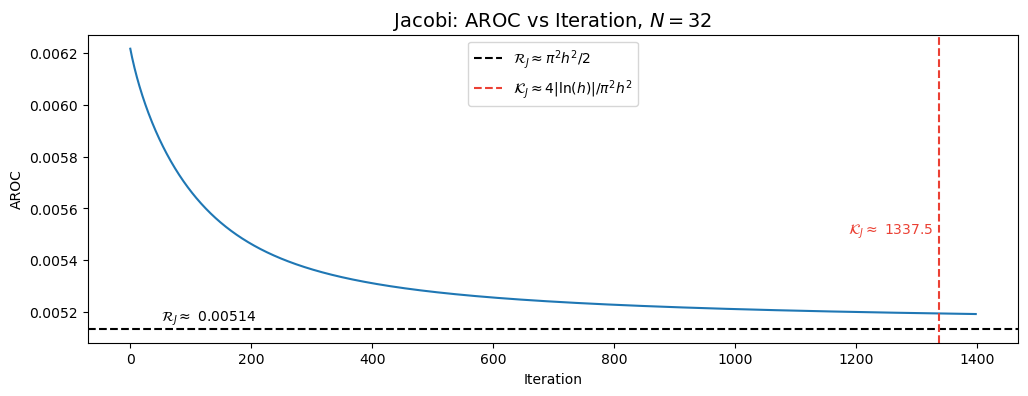

In [21]:
# Plot Jacobi's AROC vs Iteration, for N = 32
plt.figure(figsize=(12,4))
jacobi_32 = JacobiSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 1400)
plt.plot(jacobi_32["aroc"][1:])
plt.title("Jacobi: AROC vs Iteration, $N=32$",fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("AROC")
aroc_jacobi32 = JacobiTheoreticalAROC(32) 
k_jacobi32 = JacobiTheoreticalK(32)
plt.axhline(y=aroc_jacobi32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{J} \\approx \\pi^2h^2/2$')
plt.axvline(x=k_jacobi32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{J} \\approx 4|\\ln(h)|/\\pi^2h^2$')
plt.text(50, aroc_jacobi32 + 0.00003, f"$\\mathcal{{R}}_{{J}} \\approx $ {aroc_jacobi32:.5f}", color='black')
plt.text(k_jacobi32 - 150, 0.0055, f"$\\mathcal{{K}}_{{J}} \\approx $ {k_jacobi32:.1f}", color='#eb4034')
plt.legend()
plt.show()


# Gauss-Seidel Solver

In [22]:
# Gauss-Seidel Solver
def GaussSeidelSolver(U0, LAP, U, max_iter=200, tolerance = 1e-6):
    Uk = U0.copy()
    res_norm = np.full(max_iter, 0.0)
    err_norm = np.full(max_iter, 0.0)
    aroc  = np.full(max_iter, 0.0)

    N = U0.shape[0]
    h = 1.0/(N-1)
    h2 = h**2
    for k in range(max_iter):
        for i in range(1,N-1):
            for j in range(1,N-1):
                fterm  = h2*LAP[i,j]
                left   = Uk[i-1 , j]
                right  = Uk[i+1 , j]
                down   = Uk[i , j+1]
                up     = Uk[i , j-1]
                Uk[i][j] = 0.25 * (fterm + left + right + up + down)

        res_norm[k] = ResidualNorm(Uk,LAP)
        err_norm[k] = ErrorNorm(Uk, U)
        aroc[k] = AverageROC(err_norm[k], err_norm[0], k)

        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.2e}")
            # break
    return ({
        "Uk":Uk,
        "res":res_norm,
        "err":err_norm,
        "aroc":aroc
    })

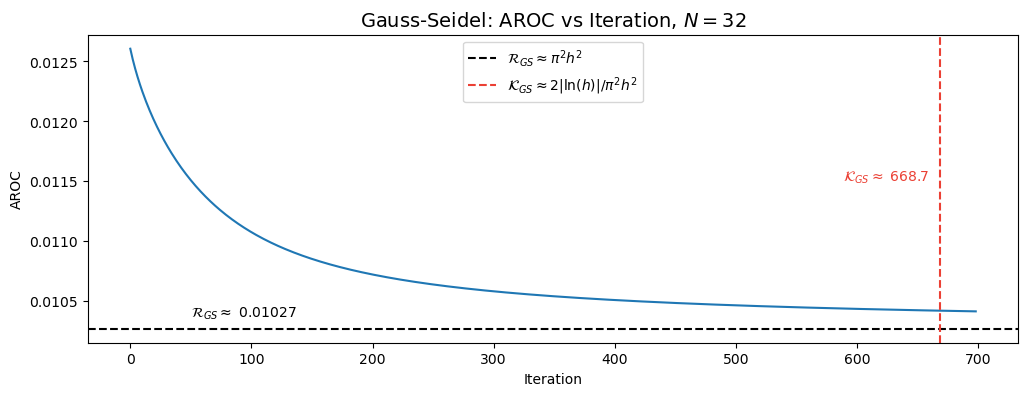

In [23]:
# Plot Gauss-Seidel's AROC vs Iteration, for N = 32
plt.figure(figsize=(12,4))
gs_32 = GaussSeidelSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 700)
plt.plot(gs_32["aroc"][1:])
plt.title("Gauss-Seidel: AROC vs Iteration, $N=32$",fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("AROC")
aroc_gs32 = GaussSeidelTheoreticalAROC(32)
k_gs32 = GaussSeidelTheoreticalK(32)
plt.axhline(y=aroc_gs32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{GS} \\approx \\pi^2h^2$')
plt.axvline(x=k_gs32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{GS} \\approx 2|\\ln(h)|/\\pi^2h^2$')
plt.text(50, aroc_gs32 + 0.0001, f"$\\mathcal{{R}}_{{GS}} \\approx $ {aroc_gs32:.5f}", color='black')
plt.text(k_gs32 - 80, 0.0115, f"$\\mathcal{{K}}_{{GS}} \\approx $ {k_gs32:.1f}", color='#eb4034')
plt.legend()
plt.show()

------------------------------

# SOR Solver

In [9]:
def SORSolver(U0, LAP, U, omega, max_iter=200, tolerance = 1e-6):
    Uk = U0.copy()
    res_norm = np.full(max_iter, 0.0)
    err_norm = np.full(max_iter, 0.0)
    aroc  = np.full(max_iter, 0.0)

    N = U0.shape[0]
    h = 1.0/(N-1) # this seems to matter for convergence of AROC. choosing 1/N changes the AROC asymptote
    h2 = h**2
    
    for k in range(max_iter):
        for i in range(1,N-1):
            for j in range(1,N-1):
                fterm   = h2*LAP[i,j]
                left    = Uk[i-1 , j]
                right   = Uk[i+1 , j]
                down    = Uk[i , j+1]
                up      = Uk[i , j-1]
                gij     = 0.25 * (fterm + left + right + down + up) # gauss-seidel
                Uk[i,j] = omega * gij + (1-omega) * Uk[i,j]
    
    
        res_norm[k] = ResidualNorm(Uk,LAP)
        err_norm[k] = ErrorNorm(Uk, U)
        aroc[k]  = AverageROC(err_norm[k], err_norm[0], k)

        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.2e}")
            # break
        
    return ({
        "Uk":Uk, 
        "res":res_norm, 
        "err":err_norm, 
        "aroc":aroc
    }) 

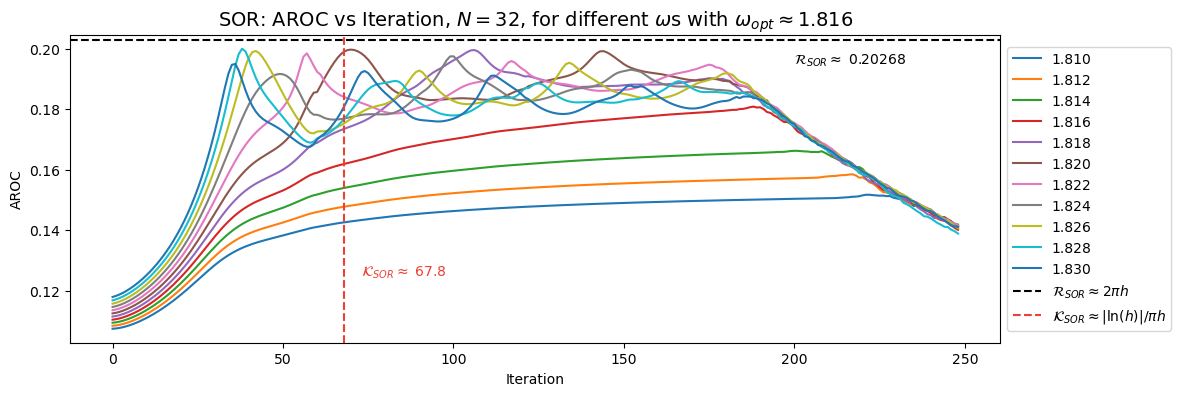

In [10]:
# look at aroc vs omega relation for a range of omegas for SOR for N = 32
plt.figure(figsize=(12,4))
for o in np.linspace(1.81,1.83,11):
    sor_omega = SORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 250)
    plt.plot(sor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SOR: AROC vs Iteration, $N=32$, for different $\\omega$s with $\\omega_{opt} \\approx 1.816$",fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("AROC")
aroc_sor32 = SORTheoreticalAROC(32)
k_sor32 = SORTheoreticalK(32)
plt.axhline(y=aroc_sor32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SOR} \\approx 2\\pi h$')
plt.axvline(x=k_sor32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SOR} \\approx |\\ln(h)|/\\pi h$')
plt.text(200, 0.195, f"$\\mathcal{{R}}_{{SOR}} \\approx $ {aroc_sor32:.5f}", color='black')
plt.text(k_sor32 + 5, 0.125, f"$\\mathcal{{K}}_{{SOR}} \\approx $ {k_sor32:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



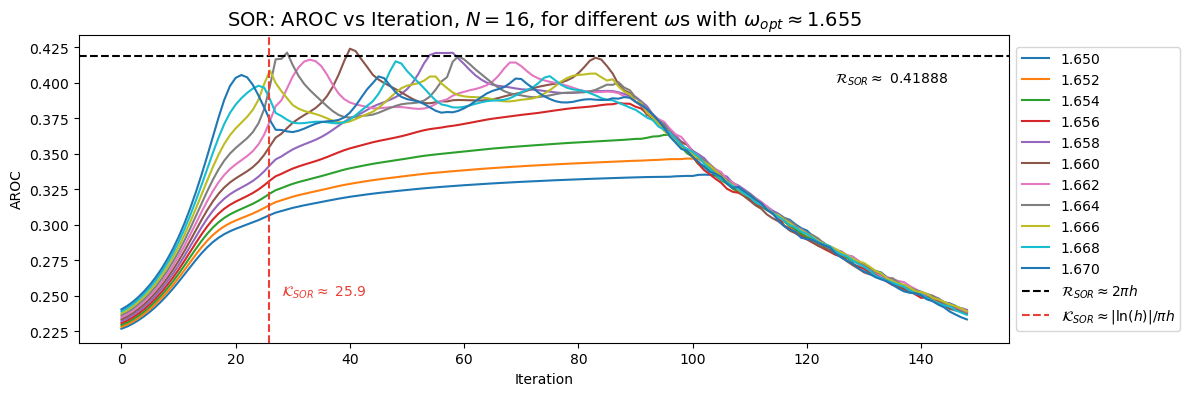

In [11]:
# look at aroc vs omega relation for a range of omegas for SOR for N = 16
plt.figure(figsize=(12,4))
for o in np.linspace(1.65,1.67,11):
    sor_omega = SORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = o, max_iter = 150)
    plt.plot(sor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SOR: AROC vs Iteration, $N=16$, for different $\\omega$s with $\\omega_{opt} \\approx 1.655$",fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("AROC")
aroc_sor16 = SORTheoreticalAROC(16)
k_sor16 = SORTheoreticalK(16)
plt.axhline(y=aroc_sor16, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SOR} \\approx 2\\pi h$')
plt.axvline(x=k_sor16, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SOR} \\approx |\\ln(h)|/\\pi h$')
plt.text(125, 0.4, f"$\\mathcal{{R}}_{{SOR}} \\approx $ {aroc_sor16:.5f}", color='black')
plt.text(k_sor16 + 2, 0.25, f"$\\mathcal{{K}}_{{SOR}} \\approx $ {k_sor16:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



------------------------------

# SSOR Solver

In [12]:
def SSORSolver(U0, LAP, U, omega, max_iter=200, tolerance=1e-6):
    N = U0.shape[0]
    h = 1.0 / (N - 1)
    h2 = h**2

    Uk = U0.copy()
    res_norm = np.full(max_iter,0.0)
    err_norm = np.full(max_iter,0.0)
    aroc = np.full(max_iter,0.0)

    for k in range(max_iter):
        
        # Forward sweep 1 --> N
        U_old = Uk.copy()
        for i in range(1, N-1):
            for j in range(1, N-1):
                f_term = h2 * LAP[i][j]
                left  = Uk[i-1][j]
                right = U_old[i+1][j]
                up    = Uk[i][j-1]
                down = U_old[i][j+1]
                gij = 0.25 * (f_term + left + right + up + down)
                Uk[i][j] = (1 - omega) * Uk[i][j] + omega * gij

        # Reverse sweep N --> 1
        U_old = Uk.copy()
        for i in range(N-2, 0, -1):
            for j in range(N-2, 0, -1):
                f_term = h2 * LAP[i][j]
                right = Uk[i+1][j]
                down  = Uk[i][j+1]
                left  = U_old[i-1][j]
                up    = U_old[i][j-1]
                gij = 0.25 * (f_term + left + right + up + down)
                Uk[i][j] = (1 - omega) * Uk[i][j] + omega * gij

        res_norm[k] = ResidualNorm(Uk, LAP)
        err_norm[k] = ErrorNorm(Uk, U)
        aroc[k]  = AverageROC(err_norm[k], err_norm[0], k)

        # if res_norm[k] < tolerance:
            # print(f"Converged after {k} iterations, residual = {res_norm[k]:.3e}")
            # break

    return ({
        "Uk":Uk, 
        "res":res_norm, 
        "err":err_norm, 
        "aroc":aroc
    }) 

In [13]:
SSORTheoreticalAROC(32)

0.10134169850289655

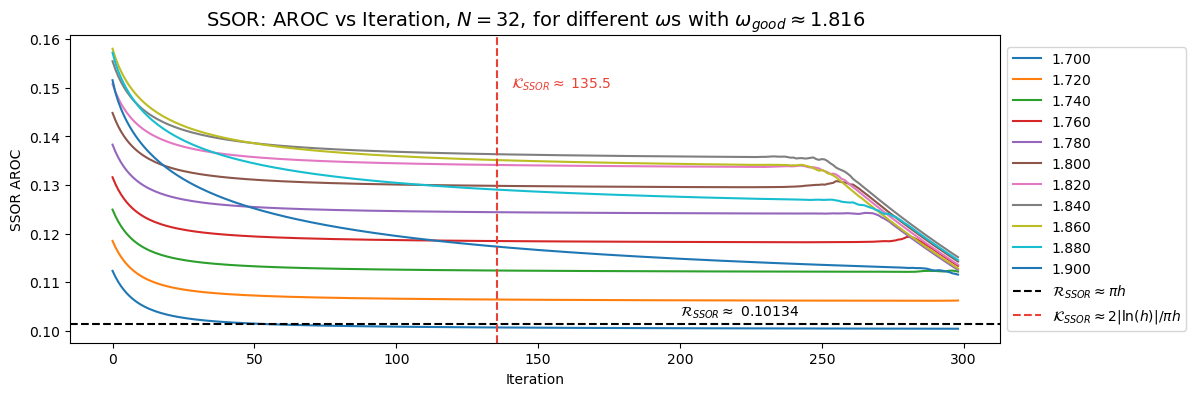

In [14]:
# plot SSOR's AROC vs iteration, for a range of omegas, at N = 32
plt.figure(figsize=(12,4))
for o in np.linspace(1.70,1.9,11):
    ssor_omega = SSORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 300)
    plt.plot(ssor_omega["aroc"][1:], label = f"{o:.3f}")
plt.title("SSOR: AROC vs Iteration, $N=32$, for different $\\omega$s with $\\omega_{good} \\approx 1.816$",fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("SSOR AROC")
aroc_ssor32 = SSORTheoreticalAROC(32)
k_ssor32 = SSORTheoreticalK(32)
plt.axhline(y=aroc_ssor32, linestyle='--', color='#000000', alpha=1, label='$\\mathcal{R}_{SSOR} \\approx \\pi h$')
plt.axvline(x=k_ssor32, linestyle='--', color='#eb4034', alpha=1, label='$\\mathcal{K}_{SSOR} \\approx 2|\\ln(h)|/\\pi h$')
plt.text(200, 0.103, f"$\\mathcal{{R}}_{{SSOR}} \\approx $ {aroc_ssor32:.5f}", color='black')
plt.text(k_ssor32 + 5, 0.15, f"$\\mathcal{{K}}_{{SSOR}} \\approx $ {k_ssor32:.1f}", color='#eb4034')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


--------------------

## Results

In [29]:
gs_32 = GaussSeidelSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 200)
jacobi_32 = JacobiSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), max_iter = 200)
sor_32 = SORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = OmegaOpt(32), max_iter = 200)
ssor_32 = SSORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = OmegaGood(32), max_iter = 200)

### Answer 1.9 b) Metrics of Error and Convergence
- The following values were evaluated/computed for $N = 32$

| Method             | Estimated Iterations to Converge ($\mathcal{K}$)               | Theoretical AROC ($\mathcal{R}$)                        | Computed AROC ($\mathcal{R}_{100}$)            | Notes                              |
|--------------------|----------------------------------------------------|----------------------------------------------|---------------------------------|------------------------------------|
| Jacobi             | $k_J \approx \frac{4|\ln h|}{\pi^2 h^2} \approx 1337$ | $R_J \approx \frac{\pi^2 h^2}{2} = 0.0051 $ | $0.0056$          |                                    |
| Gauss-Seidel (GS)  | $k_{GS} \approx \frac{2|\ln h|}{\pi^2 h^2} \approx 678$ | $R_{GS} \approx \pi^2 h^2 = 0.0102$      | $0.011$         |                                    |
| SOR                | $k_{SOR} \approx \frac{2|\ln h|}{\pi h} \approx 67$    | $R_{SOR} \approx 2 \pi h = 0.202$       | $0.169$          | Discrepancy noted from theoretical value |
| SSOR               | $k_{SSOR} \approx \frac{|\ln h|}{\pi h} \approx 135$    | $R_{SSOR} \approx \pi h = 0.1013$        | $0.133$          | Discrepancy noted from theoretical value |

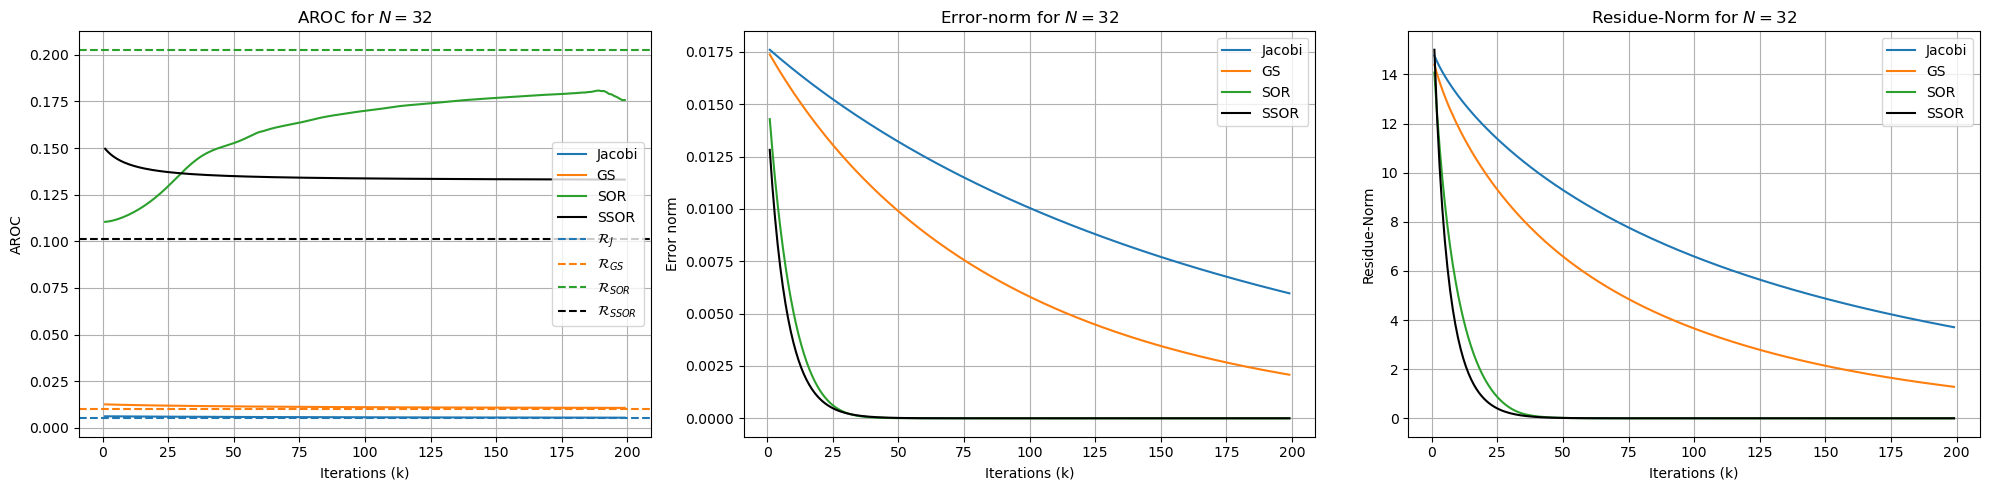

In [105]:
# Plot AROC, Error-Norm, Residue-Norm
# Slice the arrays from index 0 to 100
start, end = 1, 200
time = np.arange(start, end)

# Create subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# === AROC Plot ===
axs[0].plot(time, jacobi_32["aroc"][start:end], label='Jacobi', color='#1f77b4')  
axs[0].plot(time, gs_32["aroc"][start:end], label='GS', color='#ff7f0e')  
axs[0].plot(time, sor_32["aroc"][start:end], label='SOR', color='#2ca02c')  
axs[0].plot(time, ssor_32["aroc"][start:end], label='SSOR', color='#000000')

# Add dashed horizontal lines for theoretical AROC values
axs[0].axhline(y=aroc_jacobi32, linestyle='--', color='#1f77b4', label='$\\mathcal{R}_{J}$', linewidth=1.5)
axs[0].axhline(y=aroc_gs32, linestyle='--', color='#ff7f0e',  label='$\\mathcal{R}_{GS}$', linewidth=1.5)
axs[0].axhline(y=aroc_sor32, linestyle='--', color='#2ca02c', label='$\\mathcal{R}_{SOR}$', linewidth=1.5)
axs[0].axhline(y=aroc_ssor32, linestyle='--', color='#000000', label='$\\mathcal{R}_{SSOR}$', linewidth=1.5)

# # # Add dashed vertical lines for theoretical k values
# # axs[0].axvline(x=k_jacobi_theoretical, linestyle=':', color='#1f77b4', alpha=0.8, label='$K_{J}$')
# # axs[0].axvline(x=k_gs_theoretical, linestyle=':', color='#ff7f0e', alpha=0.8, label='$K_{GS}$')
# # axs[0].axvline(x=k_sor_theoretical, linestyle=':', color='#2ca02c', alpha=0.8, label='$K_{SOR}$')
# # axs[0].axvline(x=k_ssor_theoretical, linestyle=':', color='#000000', alpha=0.8, label='$K_{SSOR}$')

# # === Error Norm Plot ===
axs[1].plot(time, jacobi_32["err"][start:end], label='Jacobi', color='#1f77b4')  
axs[1].plot(time, gs_32["err"][start:end], label='GS', color='#ff7f0e')  
axs[1].plot(time, sor_32["err"][start:end], label='SOR', color='#2ca02c')  
axs[1].plot(time, ssor_32["err"][start:end], label='SSOR', color='#000000')


# # Add dashed vertical lines for theoretical k values
# # axs[1].axvline(x=k_jacobi_theoretical, linestyle=':', color='#1f77b4', alpha=0.8, label='$K_{J}$')
# # axs[1].axvline(x=k_gs_theoretical, linestyle=':', color='#ff7f0e', alpha=0.8, label='$K_{GS}$')
# axs[1].axvline(x=k_sor_theoretical, linestyle=':', color='#2ca02c', alpha=0.8, label='$K_{SOR}$')
# axs[1].axvline(x=k_ssor_theoretical, linestyle=':', color='#000000', alpha=0.8, label='$K_{SSOR}$')

# # === Residue Plot ===
axs[2].plot(time, jacobi_32["res"][start:end], label='Jacobi', color='#1f77b4')  
axs[2].plot(time, gs_32["res"][start:end], label='GS', color='#ff7f0e')  
axs[2].plot(time, sor_32["res"][start:end], label='SOR', color='#2ca02c')  
axs[2].plot(time, ssor_32["res"][start:end], label='SSOR', color='#000000')


# # Add dashed vertical lines for theoretical k values
# # axs[2].axvline(x=k_jacobi_theoretical, linestyle=':', color='#1f77b4', alpha=0.8, label='$K_{J}$')
# # axs[2].axvline(x=k_gs_theoretical, linestyle=':', color='#ff7f0e', alpha=0.8, label='$K_{GS}$')
# axs[2].axvline(x=k_sor_theoretical, linestyle=':', color='#2ca02c', alpha=0.8, label='$K_{SOR}$')
# axs[2].axvline(x=k_ssor_theoretical, linestyle=':', color='#000000', alpha=0.8, label='$K_{SSOR}$')



axs[0].set_title('AROC for $N=32$')
axs[0].set_xlabel('Iterations (k)')
axs[0].set_ylabel('AROC')
axs[0].grid(True)
axs[0].legend()


axs[1].set_title('Error-norm for $N=32$')
axs[1].set_xlabel('Iterations (k)')
axs[1].set_ylabel('Error norm')
axs[1].grid(True)
axs[1].legend()

axs[2].set_title('Residue-Norm for $N=32$')
axs[2].set_xlabel('Iterations (k)')
axs[2].set_ylabel('Residue-Norm')
axs[2].grid(True)
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Visualize the final solution $U[i,j]$

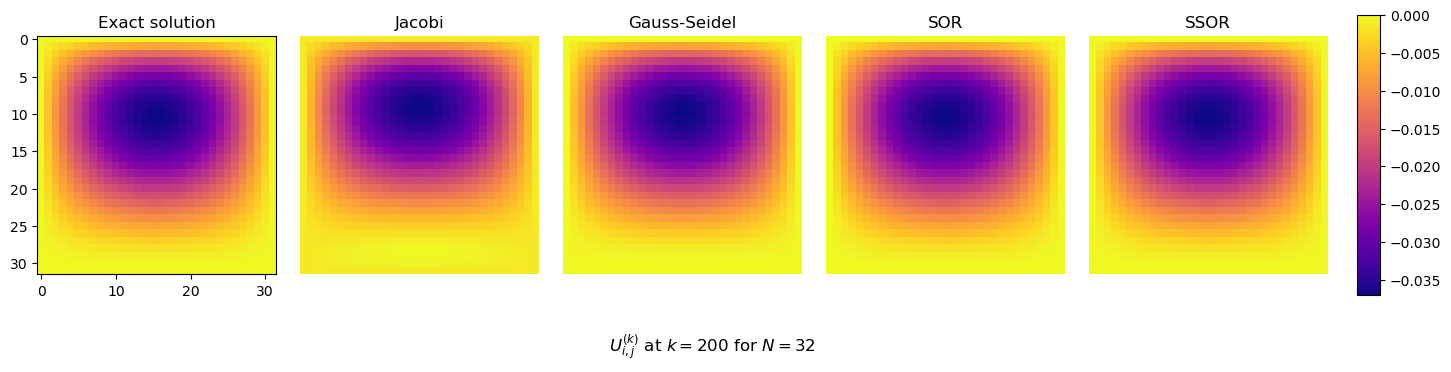

In [36]:
# Plot Final solution
# Create figure with specific size
fig = plt.figure(figsize=(15, 4))

# Define GridSpec: 1 row, 5 columns
grid_spec = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1], wspace=0.1)

# Exact solution (first plot)
ax0 = fig.add_subplot(grid_spec[0])
im = ax0.imshow(AnalyticalSolution(32), cmap='plasma')
ax0.set_title('Exact solution')

# Keep ticks only on exact solution
ax0.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Other four plots (next 4 plots in the row)
ax1 = fig.add_subplot(grid_spec[1])
ax2 = fig.add_subplot(grid_spec[2])
ax3 = fig.add_subplot(grid_spec[3])
ax4 = fig.add_subplot(grid_spec[4])

# Plot each
ax1.imshow(jacobi_32["Uk"], cmap='plasma')
ax1.set_title('Jacobi')
ax1.axis('off')

ax2.imshow(gs_32["Uk"], cmap='plasma')
ax2.set_title('Gauss-Seidel')
ax2.axis('off')

ax3.imshow(sor_32["Uk"], cmap='plasma')
ax3.set_title('SOR')
ax3.axis('off')

ax4.imshow(ssor_32["Uk"], cmap='plasma')
ax4.set_title('SSOR')
ax4.axis('off')

# Shared colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

# Final layout adjustments
plt.subplots_adjust(left=0.05, right=0.91, top=0.92, bottom=0.08)
fig.text(0.5, 0.02, f"$U_{{i,j}}^{{(k)}}$ at $k = 200$ for $N = 32$", ha='center', va='center', fontsize=12)

plt.show()


## Problem 1.10
For the Jacobi method and Gauss-Seidel method, graph $ -\ln \mathcal{R}_{100}$ versus $\ln N = −\ln h$ for $N = 16, 32, 64$. \
For the SOR method (for $\omega = \omega_{opt}$), and SSOR method (for $\omega = \omega_{good}$), compute and graph $ -\ln \mathcal{R}_{100}$ versus $\ln N = −\ln h$ for $N = 16, 32, 64$\
Compare the dependence of $\mathcal{R}$ on $h$ with the theoretical dependence of $\mathcal{R}$ predicted in (1.37)

In [40]:
# Solve Jacobi, GS, SOR, SSOR for N = 16
jacobi_16 = JacobiSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), max_iter = 200)
gs_16 = GaussSeidelSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), max_iter = 200)
sor_16 = SORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = OmegaOpt(16), max_iter = 200)
ssor_16 = SSORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = OmegaGood(16), max_iter = 200)

In [39]:
# Solve Jacobi, GS, SOR, SSOR for N = 64
jacobi_64 = JacobiSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), max_iter = 200)
gs_64 = GaussSeidelSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), max_iter = 200)
sor_64 = SORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = OmegaOpt(64), max_iter = 200)
ssor_64 = SSORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = OmegaGood(64), max_iter = 200)

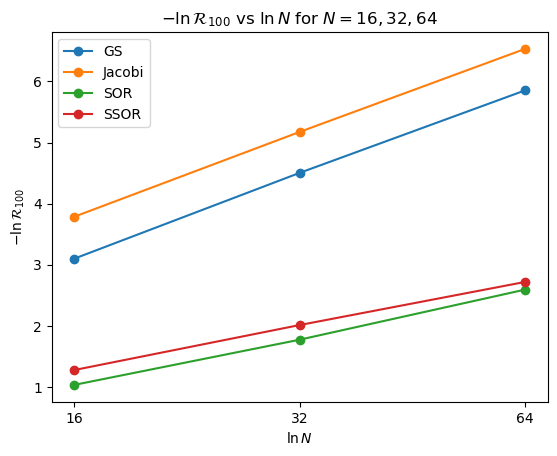

In [93]:


plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([gs_16["aroc"][100], gs_32["aroc"][100], gs_64["aroc"][100]])),
    label = "GS",
    marker = "o"
)

plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([jacobi_16["aroc"][100], jacobi_32["aroc"][100], jacobi_64["aroc"][100]])),
    label = "Jacobi",
    marker = "o"
)
plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([sor_16["aroc"][100], sor_32["aroc"][100], sor_64["aroc"][100]])),
    label = "SOR",
    marker = "o"
)
plt.plot( 
    np.log(np.array([16,32,64])),
    (-1)*np.log(np.array([ssor_16["aroc"][100], ssor_32["aroc"][100], ssor_64["aroc"][100]])),
    label = "SSOR",
    marker = "o"
)
plt.ylabel("$-\\ln \\mathcal{R}_{100}$")
plt.xlabel("$\\ln N$")

plt.title(f"$- \\ln \\mathcal{{R}}_{{100}}$ vs $\\ln N$ for $N=16,32,64$")
plt.legend()
plt.xticks(np.log([16, 32, 64]), ["16", "32", "64"])
plt.show()

# Problem 1.11
For the SOR and SSOR methods with $N = 16, 32, 64$, graph $-\ln \mathcal{R}_{100}$ vs $\omega$ for $\omega = 1 + 0.5 l$ for $ l = 0,1,...20$.  \
Interpret this graph using the result (1.33) and the theory in this section.

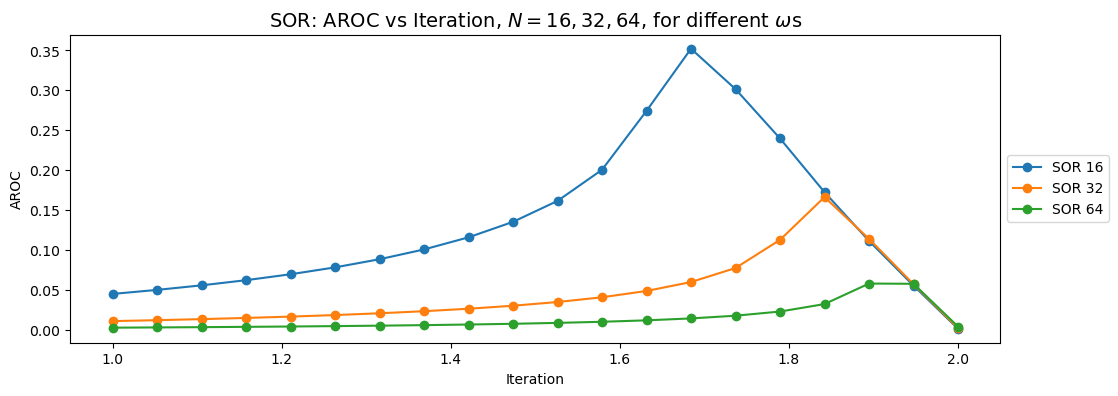

In [110]:
# look at aroc vs omega relation for a range of omegas for SOR for N = 16
plt.figure(figsize=(12,4))
omega_vals = np.linspace(1.0, 2.0, 20)
sor16_aroc_100 = []
sor32_aroc_100 = []
sor64_aroc_100 = []

for o in omega_vals:
    sor16_omega = SORSolver(DefaultInitialGuess(16), AnalyticalLaplacian(16), AnalyticalSolution(16), omega = o, max_iter = 150)
    sor32_omega = SORSolver(DefaultInitialGuess(32), AnalyticalLaplacian(32), AnalyticalSolution(32), omega = o, max_iter = 150)
    sor64_omega = SORSolver(DefaultInitialGuess(64), AnalyticalLaplacian(64), AnalyticalSolution(64), omega = o, max_iter = 150)
    sor16_aroc_100.append(sor16_omega["aroc"][100])
    sor32_aroc_100.append(sor32_omega["aroc"][100])
    sor64_aroc_100.append(sor64_omega["aroc"][100])


plt.plot(omega_vals,sor16_aroc_100, marker="o",label = f"SOR 16")
plt.plot(omega_vals,sor32_aroc_100, marker="o",label = f"SOR 32")
plt.plot(omega_vals,sor64_aroc_100, marker="o",label = f"SOR 64")

plt.title("SOR: AROC vs Iteration, $N=16,32,64$, for different $\\omega$s",fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("AROC")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [127]:
# evaluate the spectral-radius of a Jacobi Iteration Matrix
def rho_GJ(N):
    h = 1/(N-1)
    return np.cos(np.pi * h)

# evaluate the spectral radius 
def rho_H(omega, rho_GJ, omega_opt):
    if 1 <= omega <= omega_opt:
        term = (omega * rho_GJ + np.sqrt((omega**2) * (rho_GJ**2) - 4 * (omega - 1))) / 2
        return term**2
    elif omega >= omega_opt:
        return rho_GJ / (omega - 1)
    else:
        raise ValueError("omega must be >= 1")


In [128]:
rho_GJ(16)

np.float64(0.9781476007338057)

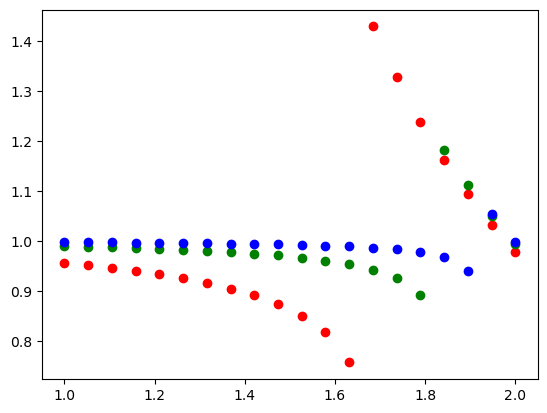

In [137]:

for o in omega_vals:
    plt.scatter(o,rho_H(o,rho_GJ(16),OmegaOpt(16)), label="16", color="r")
    plt.scatter(o,rho_H(o,rho_GJ(32),OmegaOpt(32)), label="32", color="g")
    plt.scatter(o,rho_H(o,rho_GJ(64),OmegaOpt(64)), label="64", color="b")
# plt.legend()
plt.show()


## extra - animating $U_{ij}$ for N=32

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set the size of the matrix (e.g., 10x10)
matrix_size = (32, 32)

# Initialize the matrix with random values between 0 and 1
matrix = np.random.rand(*matrix_size)

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Initialize the heatmap plot with the matrix
cax = ax.matshow(matrix, cmap='viridis')

# Add a colorbar to represent the values
fig.colorbar(cax)

# Function to update the matrix values in each frame
def update(frame):
    global matrix
    # Update the matrix by adding small random noise (you can customize this update logic)
    matrix += np.random.normal(scale=0.1, size=matrix_size)
    
    # Keep matrix values within a reasonable range (e.g., 0 to 1)
    matrix = np.clip(matrix, 0, 1)
    
    # Update the plot data
    cax.set_array(matrix)
    
    return [cax]

# Create the animation: 100 iterations with the update function
ani = FuncAnimation(fig, update, frames=100, blit=True, interval=50)

# Save the animation to a .gif file (you can change the filename)
gif_filename = 'matrix_animation.gif'  # Use a temporary path or any path
ani.save(gif_filename, writer='pillow', fps=20)

# Display the animation directly in the notebook
# HTML(f'<img src="{gif_filename}" />')


In [ ]:
from IPython.display import HTML
# HTML(f'<img src="example.gif" />')
from IPython.display import Image
# Image(url='example.gif')  